<a href="https://colab.research.google.com/github/coding4better/FaceRecognition/blob/main/content/a-pre-processing/time_series_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from torch.utils.data import random_split
import torch.nn as nn
import json
import tqdm

In [12]:
import ast  # 导入 ast 模块

class AudioDataset(Dataset):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        # 使用 ast.literal_eval 安全地解析字符串
        left_sequence = np.array(ast.literal_eval(row["Left_Sequence"]))  # 将字符串转换为数组
        right_sequence = np.array(ast.literal_eval(row["Right_Sequence"]))
        label_left = row["Polyp Left Length Ratio"]
        label_right = row["Polyp Right Length Ratio"]

        # 转换为 PyTorch 张量
        left_sequence = torch.FloatTensor(left_sequence).unsqueeze(-1)  # 增加通道维度
        right_sequence = torch.FloatTensor(right_sequence).unsqueeze(-1)
        label_left = torch.FloatTensor([label_left])
        label_right = torch.FloatTensor([label_right])

        return left_sequence, right_sequence, label_left, label_right
# # 定义自定义数据集类
# class AudioDataset(Dataset):
#     def __init__(self, csv_file):
#         self.data = pd.read_csv(csv_file)

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         row = self.data.iloc[idx]
#         left_sequence = np.array(json.loads(row["Left_Sequence"]))  # 将字符串转换为数组
#         right_sequence = np.array(json.loads(row["Right_Sequence"]))
#         label_left = torch.FloatTensor([row["Polyp Left Length Ratio"]])
#         label_right = torch.FloatTensor([row["Polyp Right Length Ratio"]])

#         # 转换为 PyTorch 张量，并确保形状为 (sequence_length, input_size)
#         left_sequence = torch.FloatTensor(left_sequence).unsqueeze(-1)
#         right_sequence = torch.FloatTensor(right_sequence).unsqueeze(-1)

#         return left_sequence, right_sequence, label_left, label_right



In [13]:
# 加载数据集
dataset = AudioDataset(r"/content/drive/MyDrive/matched_audio_sequences.csv")

# 划分数据集
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

# 创建 DataLoader
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=32)


In [14]:
train_dataloader.dataset[0]

(tensor([[0.0558],
         [0.1275],
         [0.1614],
         ...,
         [0.0000],
         [0.0000],
         [0.0000]]),
 tensor([[-0.3283],
         [-0.5332],
         [-0.4442],
         ...,
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]]),
 tensor([0.]),
 tensor([0.2731]))

In [ ]:
class DualTaskRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(DualTaskRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN 层
        self.rnn_left = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.rnn_right = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # 回归任务的全连接层
        self.fc_left = nn.Linear(hidden_size, output_size)
        self.fc_right = nn.Linear(hidden_size, output_size)

        # 预留分类任务的接口
        self.fc_classifier = nn.Linear(hidden_size * 2, 1)  # 假设分类任务是二分类

    def forward(self, x_left, x_right):
        # 处理左声道
        h0_left = torch.zeros(self.num_layers, x_left.size(0), self.hidden_size).to(x_left.device)
        out_left, _ = self.rnn_left(x_left, h0_left)
        out_left = self.fc_left(out_left[:, -1, :])  # 取最后一个时间步的输出

        # 处理右声道
        h0_right = torch.zeros(self.num_layers, x_right.size(0), self.hidden_size).to(x_right.device)
        out_right, _ = self.rnn_right(x_right, h0_right)
        out_right = self.fc_right(out_right[:, -1, :])  # 取最后一个时间步的输出

        # 预留分类任务的接口
        combined_features = torch.cat((out_left, out_right), dim=1)
        classification_output = torch.sigmoid(self.fc_classifier(combined_features))

        return out_left, out_right, classification_output


In [ ]:
model = DualTaskRNN(input_size=1, hidden_size=64, num_layers=2, output_size=1)
criterion = nn.MSELoss()  # 回归任务使用均方误差损失
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 训练循环
num_epochs = 10

In [15]:
# 定义模型
class ChannelNet(nn.Module):
    def __init__(self, input_dim=1, hidden_size=64, num_layers=2):
        super(ChannelNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_left = nn.LSTM(input_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.rnn_right = nn.LSTM(input_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc_left = nn.Linear(hidden_size * 2, 1)
        self.fc_right = nn.Linear(hidden_size * 2, 1)

    def forward(self, x_left, x_right):
        # 处理左声道
        h0_left = torch.zeros(self.num_layers * 2, x_left.size(0), self.hidden_size).to(x_left.device)
        c0_left = torch.zeros(self.num_layers * 2, x_left.size(0), self.hidden_size).to(x_left.device)
        out_left, _ = self.rnn_left(x_left, (h0_left, c0_left))
        out_left = self.fc_left(out_left[:, -1, :])  # 取最后一个时间步的输出

        # 处理右声道
        h0_right = torch.zeros(self.num_layers * 2, x_right.size(0), self.hidden_size).to(x_right.device)
        c0_right = torch.zeros(self.num_layers * 2, x_right.size(0), self.hidden_size).to(x_right.device)
        out_right, _ = self.rnn_right(x_right, (h0_right, c0_right))
        out_right = self.fc_right(out_right[:, -1, :])  # 取最后一个时间步的输出

        return out_left, out_right


In [16]:
# 定义评估函数
def evaluate(model, dataloader):
    model.eval()
    val_loss_left = 0
    val_loss_right = 0
    with torch.no_grad():
        for left_sequence, right_sequence, label_left, label_right in dataloader:
            left_sequence = left_sequence.to(device)
            right_sequence = right_sequence.to(device)
            label_left = label_left.to(device)
            label_right = label_right.to(device)

            pred_left, pred_right = model(left_sequence, right_sequence)
            val_loss_left += criterion(pred_left, label_left).item()
            val_loss_right += criterion(pred_right, label_right).item()

    val_loss_left /= len(dataloader)
    val_loss_right /= len(dataloader)
    return val_loss_left, val_loss_right

In [17]:
# 初始化模型、损失函数和优化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChannelNet(input_dim=1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
# 初始化记录变量
train_losses = []
val_losses_left, val_losses_right = [], []

# 训练循环
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0

    for left_sequence, right_sequence, label_left, label_right in tqdm.tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        left_sequence = left_sequence.to(device)
        right_sequence = right_sequence.to(device)
        label_left = label_left.to(device)
        label_right = label_right.to(device)

        # 前向传播
        pred_left, pred_right = model(left_sequence, right_sequence)

        # 计算损失
        loss_left = criterion(pred_left, label_left)
        loss_right = criterion(pred_right, label_right)
        total_loss = loss_left + loss_right

        # 反向传播和优化
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_train_loss += total_loss.item()

    # 记录训练损失
    train_losses.append(epoch_train_loss / len(train_dataloader))

    # 验证集评估
    val_loss_left, val_loss_right = evaluate(model, val_dataloader)
    val_losses_left.append(val_loss_left)
    val_losses_right.append(val_loss_right)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss (Left): {val_loss_left:.4f}, Val Loss (Right): {val_loss_right:.4f}")


Epoch 1/10:   0%|          | 0/23 [00:19<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 8.39 GiB. GPU 0 has a total capacity of 14.74 GiB of which 2.33 GiB is free. Process 2913 has 12.41 GiB memory in use. Of the allocated memory 12.28 GiB is allocated by PyTorch, and 11.25 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

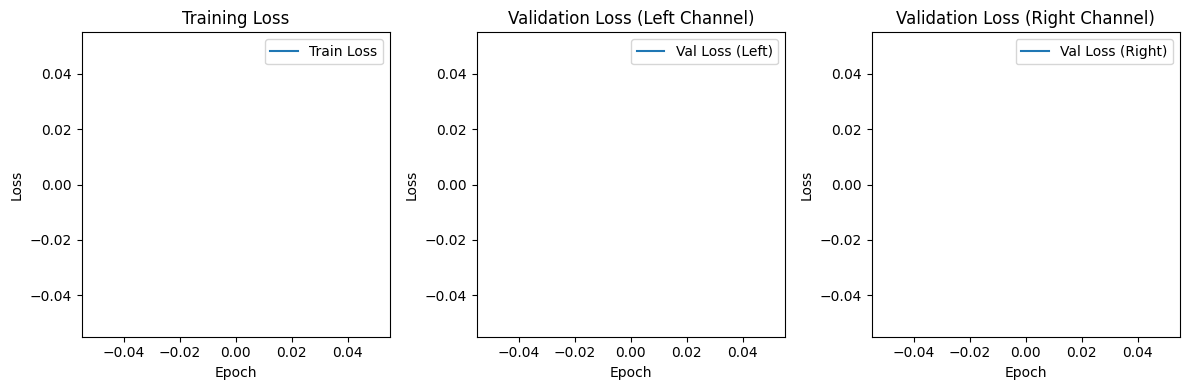

In [ ]:
# 绘制训练过程中的损失曲线
from matplotlib import pyplot as plt
def plot_training_metrics(train_losses, val_losses_left, val_losses_right):
    plt.figure(figsize=(12, 4))

    # 绘制训练损失
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()

    # 绘制验证集左声道损失
    plt.subplot(1, 3, 2)
    plt.plot(val_losses_left, label="Val Loss (Left)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Validation Loss (Left Channel)")
    plt.legend()

    # 绘制验证集右声道损失
    plt.subplot(1, 3, 3)
    plt.plot(val_losses_right, label="Val Loss (Right)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Validation Loss (Right Channel)")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_metrics(train_losses, val_losses_left, val_losses_right)